# Project enda : Example A

In this example notebook, we will show how to read and manipulate contracts data on a small sample.
Then we will show how to align it to consumption, weather and TSO forecast data in order to train it.

To start, you will need a python 3 installation (use a virtual environment), and to have installed these packages: enda, pandas, scikit-learn:

```bash
# create virtualenv, can use for instance {path_to_python3.9} instead of just "python3"
python3 -m venv {path-to-venv}    
source {path-to-venv}/bin/activate
which python  # check python path
python --version  # check python version
pip install --upgrade pip  # upgrade pip, the package manager
pip install pandas sklearn enda matplotlib
jupyter notebook  # lauch jupyter
```

Then you can download the dataset `example_a`. It is also used for unit-tests in project enda.

The dataset is a micro-example of the data we typically have. We pretend **we are exactly on '2020-09-20'** and want to predict our SLP customers load for the next 3 days, from '2020-09-21' to ''2020-09-23' at a 30 min time-step. In this example, we have only 3 days of training data , from '2020-09-16' to '2020-09-19' (data from '2020-09-20' is not available because we usually do not have the most recent consumption data). 

The files contents:
- `contracts.csv` contains a list of 6 electricity customer contracts with different characteristics. Some have an end date in the future (after '2020-09-20'). 
- `historic_load_measured.csv` : the past load for 2 groups of customers smart_metered and slp, from '2020-09-16' to '2020-09-19'
- `weather_and_tso_forecasts.csv` : 2 external forecasts: temperature and the total load on our TSO's grid, available in the past and in the future: from '2020-09-16' to '2020-09-23'. 

You can now follow this tutorial step by step.



In [1]:
import enda
import pandas as pd
import os

In [2]:
# replace with the folder path where you put example_a
DIR = '/Users/emmanuel.charon/Documents/CodeProjects/enercoop/enda/data/example_a'

## I. Dealing with contracts data

In [3]:
contracts = enda.Contracts.read_contracts_from_file(os.path.join(DIR, "contracts.csv"))

In [4]:
contracts

,customer_id,contract_id,date_start,date_end_exclusive,sub_contract_end_reason,subscribed_power_kva,smart_metered,profile,customer_type,specific_price,estimated_annual_consumption_kwh,tension
0,1,1-a,2020-09-16,2020-09-19,changed subscribed power,6,False,RES2,residential,False,4500,BT<=36kVA RES
1,1,1-b,2020-09-19,NaT,NaN,9,False,RES2,residential,False,4500,BT<=36kVA RES
2,2,2-a,2020-09-17,2020-09-21,contract end,15,True,NaN,professionnal,True,20000,BT<=36kVA PRO
3,3,3-a,2020-09-18,NaT,NaN,3,True,NaN,residential,False,3000,BT<=36kVA RES
4,4,4-a,2020-09-19,NaT,NaN,12,False,PRO1,professionnal,False,10000,BT<=36kVA PRO
5,5,5-a,2020-09-18,2020-09-26,contract end,9,False,RES2,residential,True,5000,BT<=36kVA RES
6,6,6-a,2020-09-23,NaT,NaN,6,False,RES2,residential,True,4000,BT<=36kVA RES


In [5]:
# put each contract inside a group, here just 2 groups : smart_metered and SLP
contracts["group"] = contracts.apply(lambda row: 'smart_metered' if row["smart_metered"] else 'slp', axis=1)
# add a variable to count the number of contracts for each row
contracts["num_contracts"] = 1

In [6]:
# count the running total of ["num_contracts", "subscribed_power_kva", "estimated_annual_consumption_kwh"]  each day
portfolio_by_day = enda.Contracts.compute_portfolio_by_day(
    contracts, 
    columns_to_sum = ["num_contracts", "subscribed_power_kva", "estimated_annual_consumption_kwh"],
    date_start_col="date_start",
    date_end_exclusive_col="date_end_exclusive",
    group_column="group"
)

In [7]:
# note that portfolio_by_day can have dates in the future if some contracts have a future date_end
portfolio_by_day

measure    estimated_annual_consumption_kwh               num_contracts  \
group                                   slp smart_metered           slp   
date                                                                      
2020-09-16                           4500.0           0.0           1.0   
2020-09-17                           4500.0       20000.0           1.0   
2020-09-18                           9500.0       23000.0           2.0   
2020-09-19                          19500.0       23000.0           3.0   
2020-09-20                          19500.0       23000.0           3.0   
2020-09-21                          19500.0        3000.0           3.0   
2020-09-22                          19500.0        3000.0           3.0   
2020-09-23                          23500.0        3000.0           4.0   
2020-09-24                          23500.0        3000.0           4.0   
2020-09-25                          23500.0        3000.0           4.0   
2020-09-26                          18500.0        3000.0           3.0   

measure                  subscribed_power_kva                
group      smart_metered                  slp smart_metered  
date                                                         
2020-09-16           0.0                  6.0           0.0  
2020-09-17           1.0                  6.0          15.0  
2020-09-18           2.0                 15.0          18.0  
2020-09-19           2.0                 30.0          18.0  
2020-09-20           2.0                 30.0          18.0  
2020-09-21           1.0                 30.0           3.0  
2020-09-22           1.0                 30.0           3.0  
2020-09-23           1.0                 36.0           3.0  
2020-09-24           1.0                 36.0           3.0  
2020-09-25           1.0                 36.0           3.0  
2020-09-26           1.0                 27.0           3.0

In [8]:
# restrict/extend the portfolio_by_day to desired dates 
portfolio_by_day = enda.Contracts.get_portfolio_between_dates(
    portfolio_by_day, 
    start_datetime = pd.to_datetime('2020-09-16'),
    end_datetime_exclusive = pd.to_datetime('2020-09-24')
)

In [9]:
portfolio_by_day

measure    estimated_annual_consumption_kwh               num_contracts  \
group                                   slp smart_metered           slp   
date                                                                      
2020-09-16                           4500.0           0.0           1.0   
2020-09-17                           4500.0       20000.0           1.0   
2020-09-18                           9500.0       23000.0           2.0   
2020-09-19                          19500.0       23000.0           3.0   
2020-09-20                          19500.0       23000.0           3.0   
2020-09-21                          19500.0        3000.0           3.0   
2020-09-22                          19500.0        3000.0           3.0   
2020-09-23                          23500.0        3000.0           4.0   

measure                  subscribed_power_kva                
group      smart_metered                  slp smart_metered  
date                                                         
2020-09-16           0.0                  6.0           0.0  
2020-09-17           1.0                  6.0          15.0  
2020-09-18           2.0                 15.0          18.0  
2020-09-19           2.0                 30.0          18.0  
2020-09-20           2.0                 30.0          18.0  
2020-09-21           1.0                 30.0           3.0  
2020-09-22           1.0                 30.0           3.0  
2020-09-23           1.0                 36.0           3.0

In [10]:
# turn the portfolio_by_day into a portfolio timeseries with our desired freq and timezone
portfolio = enda.TimeSeries.interpolate_daily_to_sub_daily_data(
    portfolio_by_day,
    freq='30min', 
    tz='Europe/Paris'
)

In [11]:
portfolio

measure                   estimated_annual_consumption_kwh                \
group                                                  slp smart_metered   
time                                                                       
2020-09-16 00:00:00+02:00                           4500.0           0.0   
2020-09-16 00:30:00+02:00                           4500.0           0.0   
2020-09-16 01:00:00+02:00                           4500.0           0.0   
2020-09-16 01:30:00+02:00                           4500.0           0.0   
2020-09-16 02:00:00+02:00                           4500.0           0.0   
...                                                    ...           ...   
2020-09-23 21:30:00+02:00                          23500.0        3000.0   
2020-09-23 22:00:00+02:00                          23500.0        3000.0   
2020-09-23 22:30:00+02:00                          23500.0        3000.0   
2020-09-23 23:00:00+02:00                          23500.0        3000.0   
2020-09-23 23:30:00+02:00                          23500.0        3000.0   

measure                   num_contracts               subscribed_power_kva  \
group                               slp smart_metered                  slp   
time                                                                         
2020-09-16 00:00:00+02:00           1.0           0.0                  6.0   
2020-09-16 00:30:00+02:00           1.0           0.0                  6.0   
2020-09-16 01:00:00+02:00           1.0           0.0                  6.0   
2020-09-16 01:30:00+02:00           1.0           0.0                  6.0   
2020-09-16 02:00:00+02:00           1.0           0.0                  6.0   
...                                 ...           ...                  ...   
2020-09-23 21:30:00+02:00           4.0           1.0                 36.0   
2020-09-23 22:00:00+02:00           4.0           1.0                 36.0   
2020-09-23 22:30:00+02:00           4.0           1.0                 36.0   
2020-09-23 23:00:00+02:00           4.0           1.0                 36.0   
2020-09-23 23:30:00+02:00           4.0           1.0                 36.0   

measure                                  
group                     smart_metered  
time                                     
2020-09-16 00:00:00+02:00           0.0  
2020-09-16 00:30:00+02:00           0.0  
2020-09-16 01:00:00+02:00           0.0  
2020-09-16 01:30:00+02:00           0.0  
2020-09-16 02:00:00+02:00           0.0  
...                                 ...  
2020-09-23 21:30:00+02:00           3.0  
2020-09-23 22:00:00+02:00           3.0  
2020-09-23 22:30:00+02:00           3.0  
2020-09-23 23:00:00+02:00           3.0  
2020-09-23 23:30:00+02:00           3.0  

[384 rows x 6 columns]

In [12]:
# we will focus on just one group of customers here: SLP customers
portfolio_slp = portfolio.drop('smart_metered', axis=1, level=1)
portfolio_slp.columns = portfolio_slp.columns.droplevel(1)
portfolio_slp

measure,estimated_annual_consumption_kwh,num_contracts,subscribed_power_kva
time,,,
2020-09-16 00:00:00+02:00,4500.0,1.0,6.0
2020-09-16 00:30:00+02:00,4500.0,1.0,6.0
2020-09-16 01:00:00+02:00,4500.0,1.0,6.0
2020-09-16 01:30:00+02:00,4500.0,1.0,6.0
2020-09-16 02:00:00+02:00,4500.0,1.0,6.0
...,...,...,...
2020-09-23 21:30:00+02:00,23500.0,4.0,36.0
2020-09-23 22:00:00+02:00,23500.0,4.0,36.0
2020-09-23 22:30:00+02:00,23500.0,4.0,36.0


## II. Making a (really) basic prediction

In [13]:
# read historical load, weather and TSO forecast data
historic_load_measured = pd.read_csv(os.path.join(DIR, "historic_load_measured.csv"))
weather_and_tso_forecasts = pd.read_csv(os.path.join(DIR, "weather_and_tso_forecasts.csv"))

In [14]:
# correctly format 'time' as a pandas.DatetimeIndex of dtype: datetime[ns, tzinfo]
for df in [historic_load_measured, weather_and_tso_forecasts]:
    df['time'] = pd.to_datetime(df['time'])
    df['time'] = enda.TimeSeries.align_timezone(df['time'], tzinfo = 'Europe/Paris')
    df.set_index('time', inplace=True)

In [15]:
historic_load_measured

,slp_kw,smart_metered_kw
time,,
2020-09-16 00:00:00+02:00,100.0,274.0
2020-09-16 00:30:00+02:00,94.0,282.0
2020-09-16 01:00:00+02:00,95.7,264.3
2020-09-16 01:30:00+02:00,98.7,261.0
2020-09-16 02:00:00+02:00,107.7,255.0
...,...,...
2020-09-19 21:30:00+02:00,99.0,243.3
2020-09-19 22:00:00+02:00,99.7,244.3
2020-09-19 22:30:00+02:00,97.7,238.7


In [16]:
weather_and_tso_forecasts

,tso_forecast_load_mw,t_weighted
time,,
2020-09-16 00:00:00+02:00,44700.0,20.69
2020-09-16 00:30:00+02:00,42000.0,20.41
2020-09-16 01:00:00+02:00,39800.0,20.13
2020-09-16 01:30:00+02:00,40100.0,19.73
2020-09-16 02:00:00+02:00,39600.0,19.33
...,...,...
2020-09-23 21:30:00+02:00,45000.0,17.34
2020-09-23 22:00:00+02:00,43300.0,17.05
2020-09-23 22:30:00+02:00,44000.0,16.76


In [17]:
# lets create the train set with historical data
portfolio_slp_historic = portfolio_slp[portfolio_slp.index <= historic_load_measured.index.max()]

slp_historic = pd.merge(
    portfolio_slp_historic, 
    historic_load_measured.drop(columns='smart_metered_kw'), 
    how='inner', left_index=True, right_index=True
)

slp_historic = pd.merge(
    slp_historic, 
    weather_and_tso_forecasts, 
    how='inner', left_index=True, right_index=True
)

slp_historic

,estimated_annual_consumption_kwh,num_contracts,subscribed_power_kva,slp_kw,tso_forecast_load_mw,t_weighted
time,,,,,,
2020-09-16 00:00:00+02:00,4500.0,1.0,6.0,100.0,44700.0,20.69
2020-09-16 00:30:00+02:00,4500.0,1.0,6.0,94.0,42000.0,20.41
2020-09-16 01:00:00+02:00,4500.0,1.0,6.0,95.7,39800.0,20.13
2020-09-16 01:30:00+02:00,4500.0,1.0,6.0,98.7,40100.0,19.73
2020-09-16 02:00:00+02:00,4500.0,1.0,6.0,107.7,39600.0,19.33
...,...,...,...,...,...,...
2020-09-19 21:30:00+02:00,19500.0,3.0,30.0,99.0,41800.0,19.64
2020-09-19 22:00:00+02:00,19500.0,3.0,30.0,99.7,40700.0,19.35
2020-09-19 22:30:00+02:00,19500.0,3.0,30.0,97.7,41900.0,19.00


In [18]:
# lets create the input data for our forecast
portfolio_slp_forecast = portfolio_slp[portfolio_slp.index > pd.to_datetime('2020-09-21 00:00:00+02:00')]

slp_forecast_input = pd.merge(
    portfolio_slp_forecast, 
    weather_and_tso_forecasts, 
    how='inner', left_index=True, right_index=True
)

slp_forecast_input

,estimated_annual_consumption_kwh,num_contracts,subscribed_power_kva,tso_forecast_load_mw,t_weighted
time,,,,,
2020-09-21 00:30:00+02:00,19500.0,3.0,30.0,38500.0,18.00
2020-09-21 01:00:00+02:00,19500.0,3.0,30.0,36400.0,17.64
2020-09-21 01:30:00+02:00,19500.0,3.0,30.0,36400.0,17.42
2020-09-21 02:00:00+02:00,19500.0,3.0,30.0,35800.0,17.19
2020-09-21 02:30:00+02:00,19500.0,3.0,30.0,34700.0,16.90
...,...,...,...,...,...
2020-09-23 21:30:00+02:00,23500.0,4.0,36.0,45000.0,17.34
2020-09-23 22:00:00+02:00,23500.0,4.0,36.0,43300.0,17.05
2020-09-23 22:30:00+02:00,23500.0,4.0,36.0,44000.0,16.76


In [19]:
# create minimalistic features, for the example
def featurize(df):
    df = df.copy(deep=True)
    df["hour"] = df.index.hour
    return df

In [20]:
slp_historic = featurize(slp_historic)
slp_forecast_input = featurize(slp_forecast_input)

## Install some packages
To use enda's SKLearnLinearRegression we need `sklearn`. To save a trained model we will use `joblib`:
```bash
pip install scikit-learn joblib
```

In [21]:
# use a simple wrapper around SKlearn's LinearRegressor
import enda.ml_backends.sklearn_linreg  
from enda.ml_backends.sklearn_linreg import SKLearnLinearRegression
import joblib

In [22]:
lin_reg = SKLearnLinearRegression()
lin_reg.train(slp_historic, target_col='slp_kw')

In [23]:
# save model to a file 
model_path = os.path.join(DIR, "lin_reg.joblib")
joblib.dump(lin_reg, model_path)  
del lin_reg

In [24]:
# load model from the file 
lin_reg = joblib.load(model_path)
prediction = lin_reg.predict(slp_forecast_input, target_col='slp_kw')
assert (prediction.index == slp_forecast_input.index).all()  # verify that the pandas.DatetimeIndex is conserved

In [25]:
prediction

,slp_kw
time,
2020-09-21 00:30:00+02:00,167.627219
2020-09-21 01:00:00+02:00,119.211273
2020-09-21 01:30:00+02:00,121.670063
2020-09-21 02:00:00+02:00,104.192686
2020-09-21 02:30:00+02:00,83.680058
...,...
2020-09-23 21:30:00+02:00,173.962144
2020-09-23 22:00:00+02:00,133.401587
2020-09-23 22:30:00+02:00,151.758747


In [26]:
# for visualization matplotlib is required here
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='time'>

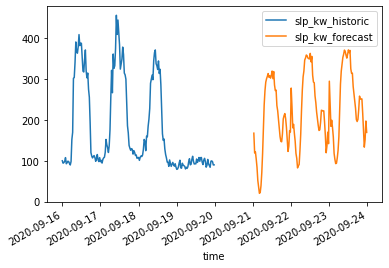

In [27]:
to_plot = pd.merge(
    slp_historic["slp_kw"].to_frame("slp_kw_historic"), 
    prediction.rename(columns={"slp_kw": "slp_kw_forecast"}), 
    how='outer', left_index=True, right_index=True
)
to_plot.plot()                             

Thats all for this introduction. Go to Example B for a more complete and in-depth example.
Thanks for reading and don't hesitate to send feeback at: emmanuel.charon@enercoop.org !